<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./Homeworks/Homework_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tavano Matteo
SM3800057
First PML homework

## Homework 1

Probabilistic Machine Learning -- Spring 2025, UniTS

In [1]:
# Libraries import
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import math
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive, MCMC, NUTS
import graphviz

### Exercise 1: KL Divergence Between Two Gaussian Distributions

Given two multivariate Gaussian distributions:

$$
p(x) = \mathcal{N}(x \mid \mu, \Sigma)
$$

$$
q(x) = \mathcal{N}(x \mid m, L)
$$

where:
- $\mu$ and $ \Sigma $ are the mean vector and covariance matrix of $ p(x) $,
- $ m $ and $ L $ are the mean vector and covariance matrix of $ q(x) $,


1. **Derive the closed-form expression** for $D_{\text{KL}}(p \parallel q)$ starting from the definition.

2. **Implement a Python function** that computes the closed-form expression of the KL divergence for two-dimensional Gaussian distributions using only **numpy** functions.

3. **Test the function** on the following concrete example where both $ p(x) $ and $q(x)$ are two-dimensional Gaussians.

4. Implement another Python function which calculates an **approximation of $D_{\text{KL}}(p \parallel q)$ from samples** of p and q. Compare the results.


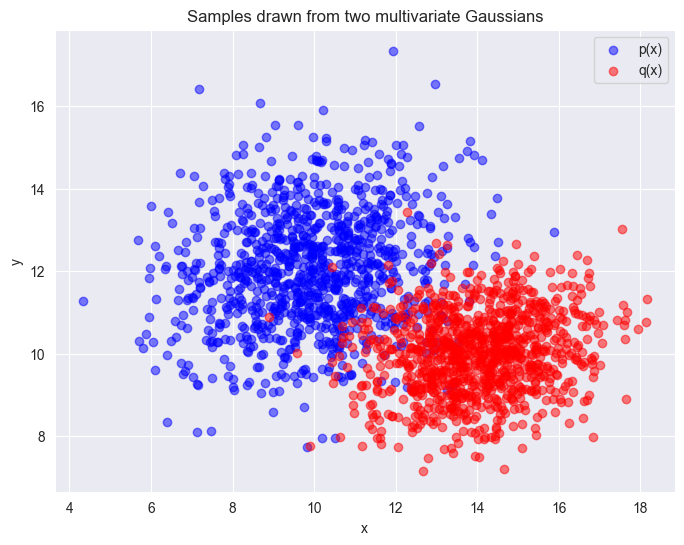

In [2]:
np.random.seed(42)

mu_p = np.array([10, 12])
sigma_p = np.array([[3, 0.5], [0.5, 2]])
mu_q = np.array([14, 10])
sigma_q = np.array([[2, 0.3], [0.3, 1]])

data_points = 1000

p_samples = np.random.multivariate_normal(mu_p, sigma_p, data_points)
q_samples = np.random.multivariate_normal(mu_q, sigma_q, data_points)

# p, q samples visualization
plt.figure(figsize=(8, 6))
plt.scatter(p_samples[:, 0], p_samples[:, 1], alpha=0.5, label='p(x)', color='blue')
plt.scatter(q_samples[:, 0], q_samples[:, 1], alpha=0.5, label='q(x)', color='red')
plt.title('Samples drawn from two multivariate Gaussians')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

**1 - Solution**

We want to compute the Kullback-Leibler (KL) divergence from a distribution $p(x)$ to a distribution $q(x)$, defined as:
$$ D_{KL}(p \parallel q) = \int p(x) \ \ln \frac{p(x)}{q(x)} dx = E_{p(x)} \left[ \ln \frac{p(x)}{q(x)} \right] $$
In our case, $p(x)$ and $q(x)$ are multivariate normal distributions in $d$ dimensions:
$$ p(x) = \mathcal{N}(x \mid \mu, \Sigma) = \frac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\left( -\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right) $$
$$ q(x) = \mathcal{N}(x \mid m, L) = \frac{1}{(2\pi)^{d/2} |L|^{1/2}} \exp\left( -\frac{1}{2} (x - m)^T L^{-1} (x - m) \right) $$
where $\mu, m \in \mathbb{R}^d$ are the means, and $\Sigma, L \in \mathbb{R}^{d \times d}$ are the symmetric positive definite covariance matrices.

First, let's compute the logarithm of the ratio $\frac{p(x)}{q(x)}$:
$$ \ln \frac{p(x)}{q(x)} = \ln p(x) - \ln q(x) $$
$$ \ln p(x) = -\frac{d}{2} \ln(2\pi) - \frac{1}{2} \ln |\Sigma| - \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) $$
$$ \ln q(x) = -\frac{d}{2} \ln(2\pi) - \frac{1}{2} \ln |L| - \frac{1}{2} (x - m)^T L^{-1} (x - m) $$
Subtracting $\ln q(x)$ from $\ln p(x)$, the constant terms $-\frac{d}{2} \ln(2\pi)$ cancel out:
$$ \ln \frac{p(x)}{q(x)} = \left( - \frac{1}{2} \ln |\Sigma| - \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right) - \left( - \frac{1}{2} \ln |L| - \frac{1}{2} (x - m)^T L^{-1} (x - m) \right) $$
$$ = \frac{1}{2} \ln |L| - \frac{1}{2} \ln |\Sigma| - \frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) + \frac{1}{2} (x - m)^T L^{-1} (x - m) $$
$$ = \frac{1}{2} \left( \ln \frac{|L|}{|\Sigma|} - (x - \mu)^T \Sigma^{-1} (x - \mu) + (x - m)^T L^{-1} (x - m) \right) $$

Now, we need to compute the expectation of this expression with respect to $p(x)$:
$$ D_{KL}(p \parallel q) = E_{p(x)} \left[ \frac{1}{2} \left( \ln \frac{|L|}{|\Sigma|} - (x - \mu)^T \Sigma^{-1} (x - \mu) + (x - m)^T L^{-1} (x - m) \right) \right] $$
Using the linearity of expectation, we can separate this into three terms:
$$ D_{KL}(p \parallel q) = \frac{1}{2} E_{p(x)} \left[ \ln \frac{|L|}{|\Sigma|} \right] - \frac{1}{2} E_{p(x)} \left[ (x - \mu)^T \Sigma^{-1} (x - \mu) \right] + \frac{1}{2} E_{p(x)} \left[ (x - m)^T L^{-1} (x - m) \right] $$

Let's evaluate each term:

1.  **First Term**: The term $\ln \frac{|L|}{|\Sigma|}$ is a constant with respect to $x$. The expectation of a constant is the constant itself.
    $$ E_{p(x)} \left[ \ln \frac{|L|}{|\Sigma|} \right] = \ln \frac{|L|}{|\Sigma|} $$

2.  **Second Term**: We need to compute $E_{p(x)} \left[ (x - \mu)^T \Sigma^{-1} (x - \mu) \right]$. This is the expectation of a quadratic form. We can use the trace trick: $(x - \mu)^T \Sigma^{-1} (x - \mu)$ is a scalar, so it's equal to its trace.
    $$ (x - \mu)^T \Sigma^{-1} (x - \mu) = \text{tr} \left( (x - \mu)^T \Sigma^{-1} (x - \mu) \right) $$
    Using the cyclic property of the trace, $\text{tr}(ABC) = \text{tr}(CAB) = \text{tr}(BCA)$:
    $$ = \text{tr} \left( \Sigma^{-1} (x - \mu) (x - \mu)^T \right) $$
    Now, take the expectation with respect to $p(x)$:
    $$ E_{p(x)} \left[ (x - \mu)^T \Sigma^{-1} (x - \mu) \right] = E_{p(x)} \left[ \text{tr} \left( \Sigma^{-1} (x - \mu) (x - \mu)^T \right) \right] $$
    Since trace and expectation are linear operators, we can swap them:
    $$ = \text{tr} \left( E_{p(x)} \left[ \Sigma^{-1} (x - \mu) (x - \mu)^T \right] \right) $$
    $$ = \text{tr} \left( \Sigma^{-1} E_{p(x)} \left[ (x - \mu) (x - \mu)^T \right] \right) $$
    The term $E_{p(x)} \left[ (x - \mu) (x - \mu)^T \right]$ is the definition of the covariance matrix of $p(x)$, which is $\Sigma$.
    $$ = \text{tr} (\Sigma^{-1} \Sigma) = \text{tr}(I_d) $$
    where $I_d$ is the $d \times d$ identity matrix. The trace of the identity matrix is the sum of its diagonal elements (all 1s), which is equal to the dimension $d$.
    $$ E_{p(x)} \left[ (x - \mu)^T \Sigma^{-1} (x - \mu) \right] = d $$

3.  **Third Term**: We need $E_{p(x)} \left[ (x - m)^T L^{-1} (x - m) \right]$. Let's rewrite the term $(x-m)$ by adding and subtracting $\mu$:
    $$ (x - m) = (x - \mu) + (\mu - m) $$
    Substitute this into the quadratic form:
    $$ (x - m)^T L^{-1} (x - m) = [(x - \mu) + (\mu - m)]^T L^{-1} [(x - \mu) + (\mu - m)] $$
    Expanding this gives:
    $$ = (x - \mu)^T L^{-1} (x - \mu) + (x - \mu)^T L^{-1} (\mu - m) + (\mu - m)^T L^{-1} (x - \mu) + (\mu - m)^T L^{-1} (\mu - m) $$
    Since $L^{-1}$ is symmetric, the two cross-terms are transposes of each other (and are scalars, thus equal): $(x - \mu)^T L^{-1} (\mu - m) = ((\mu - m)^T L^{-1} (x - \mu))^T = (\mu - m)^T L^{-1} (x - \mu)$.
    $$ = (x - \mu)^T L^{-1} (x - \mu) + 2 (\mu - m)^T L^{-1} (x - \mu) + (\mu - m)^T L^{-1} (\mu - m) $$
    Now take the expectation with respect to $p(x)$:
    $$ E_{p(x)} \left[ (x - m)^T L^{-1} (x - m) \right] = E_{p(x)} \left[ (x - \mu)^T L^{-1} (x - \mu) \right] $$
    $$ + E_{p(x)} \left[ 2 (\mu - m)^T L^{-1} (x - \mu) \right] + E_{p(x)} \left[ (\mu - m)^T L^{-1} (\mu - m) \right] $$
    Let's evaluate each part:
    - $E_{p(x)} \left[ (x - \mu)^T L^{-1} (x - \mu) \right]$: Using the same trace trick as in the second term:
            $$ E_{p(x)} \left[ \text{tr} \left( L^{-1} (x - \mu) (x - \mu)^T \right) \right] = \text{tr} \left( L^{-1} E_{p(x)} \left[ (x - \mu) (x - \mu)^T \right] \right) $$
            $$ = \text{tr} (L^{-1} \Sigma) $$
    - $E_{p(x)} \left[ 2 (\mu - m)^T L^{-1} (x - \mu) \right]$: Since $(\mu - m)^T L^{-1}$ is a constant row vector with respect to the expectation:
            $$ = 2 (\mu - m)^T L^{-1} E_{p(x)} [x - \mu] $$
            The expectation $E_{p(x)}[x - \mu]$ is the expected deviation from the mean $\mu$ under distribution $p(x)$, which is zero. $E_{p(x)}[x] = \mu$, so $E_{p(x)}[x - \mu] = \mu - \mu = 0$.
            $$ = 2 (\mu - m)^T L^{-1} (0) = 0 $$
    - $E_{p(x)} \left[ (\mu - m)^T L^{-1} (\mu - m) \right]$: This term is a constant with respect to $x$, so its expectation is itself:
            $$ = (\mu - m)^T L^{-1} (\mu - m) $$

    Combining these parts for the third term's expectation:
    $$ E_{p(x)} \left[ (x - m)^T L^{-1} (x - m) \right] = \text{tr}(L^{-1} \Sigma) + (\mu - m)^T L^{-1} (\mu - m) $$

Finally, substitute the results for the three terms back into the expression for $D_{KL}(p \parallel q)$:
$$ D_{KL}(p \parallel q) = \frac{1}{2} \left( \ln \frac{|L|}{|\Sigma|} \right) - \frac{1}{2} (d) + \frac{1}{2} \left( \text{tr}(L^{-1} \Sigma) + (\mu - m)^T L^{-1} (\mu - m) \right) $$

Rearranging the terms gives the standard closed-form expression for the KL divergence between two multivariate normal distributions:
$$ D_{KL}(\mathcal{N}(\mu, \Sigma) \parallel \mathcal{N}(m, L)) = \frac{1}{2} \left[ \text{tr}(L^{-1} \Sigma) + (\mu - m)^T L^{-1} (\mu - m) - d + \ln \frac{|L|}{|\Sigma|} \right] $$

*Notes:* Done by myself, used Gemini 2.5 for rephrase, extend the explanations and correct typos.

**2 - Solution**

In [3]:
## KL-divergence (closed-form) python function using only numpy functions:
def KL_divergence_gaussians(mu1, sigma1, mu2, sigma2):
    """
    Computes the KL divergence between two Gaussian distributions.
    (As in the previous exercise)

    Parameters:
    - mu1: ndarray of shape (2,), mean vector of the first Gaussian (p(x)).
    - sigma1: ndarray of shape (2, 2), covariance matrix of the first Gaussian (p(x)).
    - mu2: ndarray of shape (2,), mean vector of the second Gaussian (q(x)).
    - sigma2: ndarray of shape (2, 2), covariance matrix of the second Gaussian (q(x)).

    Returns:
    - KL divergence D_KL(p || q) as a float.
    """
    # determinants
    det_sigma1 = np.linalg.det(sigma1)
    det_sigma2 = np.linalg.det(sigma2)

    # inverse
    sigma2_inv = np.linalg.inv(sigma2)

    # terms
    trace_term = np.trace(np.dot(sigma2_inv, sigma1))
    mean_diff = mu1 - mu2
    quad_term = np.dot(mean_diff.T, np.dot(sigma2_inv, mean_diff))
    log_term = np.log(det_sigma2 / det_sigma1)

    return 0.5 * (trace_term + quad_term - 2 + log_term)

In [4]:
## Function test
mu1 = np.array([0, 0])
sigma1 = np.array([[1, 0.1], [0.1, 1]])

mu2 = np.array([1, 1])
sigma2 = np.array([[2, 0], [0, 2]])

kl_div = KL_divergence_gaussians(mu1, sigma1, mu2, sigma2)
print(f"KL Divergence: {kl_div}")

KL Divergence: 0.6981723484866961


**3 - Solution**

In [5]:
np.random.seed(42)

mu_p = np.array([10, 12])
sigma_p = np.array([[3, 0.5], [0.5, 2]])
mu_q = np.array([14, 10])
sigma_q = np.array([[2, 0.3], [0.3, 1]])

data_points = 1000

p_samples = np.random.multivariate_normal(mu_p, sigma_p, data_points)
q_samples = np.random.multivariate_normal(mu_q, sigma_q, data_points)

kl_div_ex3 = KL_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q)
print(f"KL Divergence: {kl_div_ex3}")


KL Divergence: 7.742145410902127


**4 - Solution**

In [6]:
def log_multivariate_normal(x, mean, covariance_matrix):
    """
    Compute the log probability density of a multivariate normal distribution.

    :param x: ndarray, shape (n_samples, n_features)
        Samples for which the log probability density is computed.
    :param mean: ndarray, shape (n_features,)
        Mean vector of the multivariate normal distribution.
    :param covariance_matrix: ndarray, shape (n_features, n_features)
        Covariance matrix of the multivariate normal distribution.

    :return: ndarray, shape (n_samples,)
        Log probability density for each sample.

    :notes: refactored using GPT-4o
    """
    # Number of dimensions/features
    num_features = len(mean)

    # Compute the difference between samples and the mean
    differences = x - mean

    # Compute the log determinant of the covariance matrix
    log_determinant = np.log(np.linalg.det(covariance_matrix))

    # Compute the inverse of the covariance matrix
    covariance_inverse = np.linalg.inv(covariance_matrix)

    # Calculate the log probability density using the formula for multivariate normal distributions
    return -0.5 * (
            np.sum(differences @ covariance_inverse * differences, axis=1) +
            num_features * np.log(2 * np.pi) +
            log_determinant
    )

In [7]:
def approx_kl_divergence(p_samples, q_samples, mean_p, cov_p, mean_q, cov_q):
    """
    Approximate the Kullback-Leibler (KL) divergence between two multivariate normal distributions.

    :param p_samples: ndarray, shape (n_samples, n_features)
        Samples drawn from distribution P.
    :param q_samples: ndarray, shape (n_samples, n_features)
        Samples drawn from distribution Q (not used in the computation).
    :param mean_p: ndarray, shape (n_features,)
        Mean vector of the distribution P.
    :param cov_p: ndarray, shape (n_features, n_features)
        Covariance matrix of the distribution P.
    :param mean_q: ndarray, shape (n_features,)
        Mean vector of the distribution Q.
    :param cov_q: ndarray, shape (n_features, n_features)
        Covariance matrix of the distribution Q.

    :return: float
        Approximation of the KL divergence D_KL(P || Q).

    :notes: refactored using GPT-4o
    """
    # Compute log densities of samples from P under the P distribution
    log_density_p_under_p = log_multivariate_normal(p_samples, mean_p, cov_p)
    log_density_p_under_q = log_multivariate_normal(p_samples, mean_q, cov_q)

    # Approximate KL divergence as the mean of the difference between the two log densities
    kl_divergence = np.mean(log_density_p_under_p - log_density_p_under_q)

    return kl_divergence


In [8]:
# call the function and compare
kl_div_ex4 = approx_kl_divergence(p_samples, q_samples, mu_p, sigma_p, mu_q, sigma_q)

print(f"Approximated KL Divergence: {kl_div_ex4}")
print(f"Exact KL Divergence: {kl_div_ex3}")

Approximated KL Divergence: 8.067734318943561
Exact KL Divergence: 7.742145410902127


### Exercise 2: Entropy of nonsingular linear transformations 

Consider a vector $x$ of continuous variables with distribution $p(\mathbf{x})$ and corresponding entropy $H[\mathbf{x}]$. Suppose that we make a nonsingular linear transformation of $x$ to obtain a new variable $y = Ax$. Show that the corresponding entropy is given by

$$
H[\mathbf{y}] = H[\mathbf{x}] + \ln |\mathbf{A}|
$$

where $|\mathbf{A}|$ denotes the determinant of $A$.


**Solution**

Let $\mathbf{x}$ be a continuous random vector in $\mathbb{R}^d$ with probability density function (PDF) $p_x(\mathbf{x})$.

The differential entropy of $\mathbf{x}$ is defined as:

$$ H[\mathbf{x}] = - \int_{\mathbb{R}^d} p_x(\mathbf{x}) \ln p_x(\mathbf{x}) d\mathbf{x} $$
Let $\mathbf{y} = A\mathbf{x}$ be a linear transformation, where $A$ is a $d \times d$ non-singular matrix (meaning $A^{-1}$ exists and $\det(A) \neq 0$).
Let $p_y(\mathbf{y})$ be the PDF of the transformed variable $\mathbf{y}$.
The entropy of $\mathbf{y}$ is:
$$ H[\mathbf{y}] = - \int_{\mathbb{R}^d} p_y(\mathbf{y}) \ln p_y(\mathbf{y}) d\mathbf{y} $$

**Finding the PDF of y**

We need to relate $p_y(\mathbf{y})$ to $p_x(\mathbf{x})$ using the change of variables formula for probability densities.
The inverse transformation is $\mathbf{x} = A^{-1}\mathbf{y}$.
The Jacobian matrix of the inverse transformation $\mathbf{x}(\mathbf{y})$ is:
$$ J = \frac{\partial \mathbf{x}}{\partial \mathbf{y}} = \frac{\partial (A^{-1}\mathbf{y})}{\partial \mathbf{y}} = A^{-1} $$
The absolute value of the determinant of the Jacobian is:
$$ |\det(J)| = |\det(A^{-1})| = \left| \frac{1}{\det(A)} \right| = \frac{1}{|\det(A)|} $$
We denote $|\det(A)|$ as $|A|$. So, $|\det(J)| = \frac{1}{|A|}$.

The change of variables formula states:
$$ p_y(\mathbf{y}) = p_x(\mathbf{x}(\mathbf{y})) |\det(J)| $$
Substituting $\mathbf{x} = A^{-1}\mathbf{y}$ and $|\det(J)| = 1/|A|$, we get:
$$ p_y(\mathbf{y}) = p_x(A^{-1}\mathbf{y}) \frac{1}{|A|} $$

**Calculating the Entropy of y**

Now we substitute this expression for $p_y(\mathbf{y})$ into the definition of $H[\mathbf{y}]$:
$$ H[\mathbf{y}] = - \int p_y(\mathbf{y}) \ln p_y(\mathbf{y}) d\mathbf{y} $$
$$ H[\mathbf{y}] = - \int \left( p_x(A^{-1}\mathbf{y}) \frac{1}{|A|} \right) \ln \left( p_x(A^{-1}\mathbf{y}) \frac{1}{|A|} \right) d\mathbf{y} $$
Using the logarithm property $\ln(a/b) = \ln(a) - \ln(b)$:
$$ H[\mathbf{y}] = - \int \frac{p_x(A^{-1}\mathbf{y})}{|A|} \left[ \ln p_x(A^{-1}\mathbf{y}) - \ln |A| \right] d\mathbf{y} $$
Split the integral into two parts:
$$ H[\mathbf{y}] = - \int \frac{p_x(A^{-1}\mathbf{y})}{|A|} \ln p_x(A^{-1}\mathbf{y}) d\mathbf{y} + \int \frac{p_x(A^{-1}\mathbf{y})}{|A|} \ln |A| d\mathbf{y} $$

**Change of Integration Variable**

To evaluate these integrals, we change the integration variable from $\mathbf{y}$ back to $\mathbf{x}$.
We use the transformation $\mathbf{x} = A^{-1}\mathbf{y}$, which implies $\mathbf{y} = A\mathbf{x}$.
The Jacobian of the forward transformation $\mathbf{y}(\mathbf{x})$ is $\frac{\partial \mathbf{y}}{\partial \mathbf{x}} = A$.
The change in the volume element is $d\mathbf{y} = |\det(A)| d\mathbf{x} = |A| d\mathbf{x}$.

Substitute $\mathbf{x}$ for $A^{-1}\mathbf{y}$ and $|A| d\mathbf{x}$ for $d\mathbf{y}$ in the integrals:

**First Integral**:
          $$ - \int \frac{p_x(\mathbf{x})}{|A|} \ln p_x(\mathbf{x}) \cdot (|A| d\mathbf{x}) = - \int p_x(\mathbf{x}) \ln p_x(\mathbf{x}) d\mathbf{x} = H[\mathbf{x}] $$

**Second Integral:**
          $$ \int \frac{p_x(\mathbf{x})}{|A|} \ln |A| \cdot (|A| d\mathbf{x}) = \int p_x(\mathbf{x}) \ln |A| d\mathbf{x} $$
          Since $\ln |A|$ is a constant with respect to the integration variable $\mathbf{x}$, we can pull it out:
          $$ = (\ln |A|) \int p_x(\mathbf{x}) d\mathbf{x} $$
          The integral of any PDF over its entire domain is 1: $\int p_x(\mathbf{x}) d\mathbf{x} = 1$.
          $$ = (\ln |A|) \times 1 = \ln |A| $$


**Final Result**

Combining the results for the two integrals:
$$ H[\mathbf{y}] = H[\mathbf{x}] + \ln |A| $$

*Notes:* Done by myself, used Gemini 2.5 for rephrase, extend the explanations and correct typos.


### Exercise 3: A good reason to go to university

You enrolled to a small tennis tournament organized by your university, that has only other three participants: let's call them $A$, $B$ and $C$.
Your first match will be against $A$, and it's scheduled after the match between $A$ and $B$ and the match between $B$ and $C$.

Assuming the result of a match $M \in \{0,1\}$ between two players $X$ and $Y$ ($M=1$ means $X$ won, $M=0$ means $Y$ won) is described by the following model:

$$M \sim Bern(p)$$

where $p = f(2(S_x - S_y))$ with $f(k) = \frac{1}{1 + e^{-k}}$ and

$$S_i \sim \mathcal{N}(0,1)$$

is the "latent" skill of player $i$ (always the same for every match that player $i$ plays)

1. Show a bayesian network describing the relationship between all the involved random variables.

2. Make a model in pyro describing the stochastic process.

3. Estimate by simulation the probability of (you) winninng against $A$, given that $A$ won against $B$ and $B$ won against $C$. Use exactly 30000 samples and call `set_seed()` before sampling.


In [9]:
def set_seed():
    seed = 0
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

**1 - Solution**

- Let $S_Y, S_A, S_B, S_C$ be the latent skills of You, Player A, Player B, and Player C, respectively.
- Let $M_{AB}$ be the result of the match between A and B (1 if A wins, 0 if B wins).
- Let $M_{BC}$ be the result of the match between B and C (1 if B wins, 0 if C wins).
- Let $M_{YA}$ be the result of the match between You and A (1 if You win, 0 if A wins).

$$S_i \sim \mathcal{N}(0, 1) \quad \text{for } i \in \{You, A, B, C\}$$

$$M_{XY} \mid S_X, S_Y \sim \text{Bernoulli}(p_{XY})$$

$$p_{XY} = f(2(S_X - S_Y)) = \frac{1}{1 + e^{-2(S_X - S_Y)}}$$

The structure of dependencies is:
- The skills $S_Y, S_A, S_B, S_C$ are independent prior random variables.
- The outcome of a match $M_{XY}$ depends only on the skills $S_X$ and $S_Y$ of the players involved.

The network consists of:
*   Four root nodes ($S_{Y}, S_A, S_B, S_C$) representing the independent skills.
*   Three child nodes ($M_{AB}, M_{BC}, M_{YA}$) representing the match outcomes. Each match outcome node has exactly two parent nodes (the skills of the two players in that match).
*   The match outcomes are conditionally independent given the skills of all players. However, observing a match outcome provides information that can propagate through the network, influencing our beliefs about the players' skills and consequently the likely outcomes of other matches involving those players. For example, observing $M_{AB}=1$ (A wins vs B) and $M_{BC}=1$ (B wins vs C) makes it more likely that $S_A > S_B$ and $S_B > S_C$, which indirectly informs the probability of $M_{YA}$.




**2 - Solution**

In [10]:
# Define the f function (sigmoid)
def f(k):
    """
    Compute the sigmoid function for the given input value.

        f(k) = 1 / (1 + exp(-k))

    :param k: The input value for which the sigmoid function should be computed.
    :return: The computed value of the sigmoid function as a float or a compatible type.
    """
    return 1.0 / (1.0 + torch.exp(-k))

In [11]:
# pyro model
def tennis_model():
    """
    Simulates tennis match outcomes by modeling players' latent skills and calculating
    win probabilities based on skill differences. The outcome of matches is sampled
    using a Bernoulli distribution.

    :return: A tuple containing the sampled values for the latent skills, match outcomes
    """

    # Sample latent skills for each player from N(0,1)
    S_Y = pyro.sample("S_Y", dist.Normal(0., 1.))
    S_A = pyro.sample("S_A", dist.Normal(0., 1.))
    S_B = pyro.sample("S_B", dist.Normal(0., 1.))
    S_C = pyro.sample("S_C", dist.Normal(0., 1.))

    # Calculate win probabilities based on skill differences
    p_AB = f(2 * (S_A - S_B))
    p_BC = f(2 * (S_B - S_C))
    p_YA = f(2 * (S_Y - S_A))

    # Sample match outcomes using Bernoulli distribution
    M_AB = pyro.sample("M_AB", dist.Bernoulli(p_AB))
    M_BC = pyro.sample("M_BC", dist.Bernoulli(p_BC))
    M_YA = pyro.sample("M_YA", dist.Bernoulli(p_YA))

    return S_Y, S_A, S_B, S_C, M_AB, M_BC, M_YA

In [12]:
# Test the model by sampling once
set_seed()
S_Y, S_A, S_B, S_C, M_AB, M_BC, M_YA = tennis_model()

print("Sampled values:")
print(f"S_Y: {S_Y:.2f}")
print(f"S_A: {S_A:.2f}")
print(f"S_B: {S_B:.2f}")
print(f"S_C: {S_C:.2f}")
print(f"M_AB: {M_AB}")
print(f"M_BC: {M_BC}")
print(f"M_YA: {M_YA}")

Sampled values:
S_Y: 1.54
S_A: -0.29
S_B: -2.18
S_C: 0.57
M_AB: 1.0
M_BC: 0.0
M_YA: 1.0


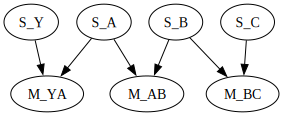

In [13]:
# render model
pyro.render_model(tennis_model)

**3 - Solution**

In [14]:
# function to simulate samples
def simulate_tennis_model(model, num_samples):
    """
    Simulates a tennis match using the provided model and a specified number of samples. The function runs simulations
    to predict outcomes of tennis matches based on the input model, utilizing Monte Carlo techniques or any other
    statistical methods defined in the model.

    :param model: Represents the statistical or predictive model used to simulate tennis match outcomes.
    :param num_samples: Number of simulations to run for predicting match outcomes.
    :return: The outcomes of the simulations.
    """

    # Store results from the simulation
    results_M_YA = []
    results_M_AB = []
    results_M_BC = []

    # Run simulation
    print(f"Running simulation with {num_samples} samples...")

    # loop to generate samples
    for _ in range(num_samples):

        predictive_run = Predictive(model, num_samples=1)()
        results_M_YA.append(predictive_run['M_YA'].item())
        results_M_AB.append(predictive_run['M_AB'].item())
        results_M_BC.append(predictive_run['M_BC'].item())

    # Convert results to tensors for easy filtering
    M_YA_samples = torch.tensor(results_M_YA)
    M_AB_samples = torch.tensor(results_M_AB)
    M_BC_samples = torch.tensor(results_M_BC)

    # Create a mask for the condition M_AB = 1 and M_BC = 1
    condition_mask = (M_AB_samples == 1) & (M_BC_samples == 1)

    # Filter the M_YA samples based on the condition
    M_YA_conditioned = M_YA_samples[condition_mask]

    # Calculate the number of samples that met the condition
    num_accepted_samples = M_YA_conditioned.shape[0]

    if num_accepted_samples == 0:
        estimated_prob = float('nan')
        print("Warning: No samples met the condition.")
    else:
        estimated_prob = torch.mean(M_YA_conditioned.float()).item()

    return num_accepted_samples, estimated_prob


In [15]:
# setting seed and num. samples
set_seed()
num_samples = 30000

# calling the function
num_accepted_samples, estimated_prob = simulate_tennis_model(tennis_model, num_samples = num_samples)

print(f"\nTotal samples generated: {num_samples}")
print(f"Number of samples satisfying the condition (M_AB=1 and M_BC=1): {num_accepted_samples}")
print(f"Estimated probability of You winning against A given the conditions: {estimated_prob:.4f}")

Running simulation with 30000 samples...

Total samples generated: 30000
Number of samples satisfying the condition (M_AB=1 and M_BC=1): 5709
Estimated probability of You winning against A given the conditions: 0.3575


### Exercise 4: Bayesian Inference on Carrier Status for Hemophilia

Hemophilia is caused by a **recessive gene** located on the **X-chromosome**. If $X^*$ denotes an X-chromosome carrying the hemophilia gene, then:
  - $X^*X^*$ represents a **female with the disease**.
  - $X^*X$ represents a **female without the disease but carrying the gene**.
  - $X^*Y$ represents a **male with the disease**.  

Mary has:  
- **An affected brother** ($X^*Y$),  
- **An unaffected mother** ($XX$ or $X^*X$),  
- **An unaffected father** ($XY$).  

Since Mary’s **brother is affected**, he must have inherited an $X^*$ from the **mother**, implying that the **mother is a carrier** ($X^*X$).  

Let $\theta$ be an indicator variable where:  
- $\theta = 1$ if Mary is a **gene carrier** ($X^*X$),  
- $\theta = 0$ if Mary is **not a carrier** ($XX$).  

Given the above information, before any additional observations, we assign the **prior probability**:

$$
P(\theta = 1) = \frac{1}{2}
$$


Mary has **two sons** (not identical twins, with unaffected father), both of whom are **not affected** by hemophilia.  

Let $y_i$ be an indicator variable where:  
- $y_i = 1$ if the $i$-th son is affected,  
- $y_i = 0$ if the $i$-th son is unaffected.  

Since males inherit their **X-chromosome from their mother**, if Mary is a carrier ($\theta = 1$), each son has a **50% chance** of being affected.  

The probability of both sons being unaffected (we denote this event, i.e. $y_1 = 0$ AND $y_2 = 0$, with $y=1$), given $\theta$, is:

$$
P(y = 1 \mid \theta) =
\begin{cases}  
0.25, & \text{if } \theta = 1 \\  
0, & \text{if } \theta = 0 
\end{cases}
$$

1) Calculate $P(y)$

2) Considering that both the sons are unaffected, calculate the posterior $P(\theta = 1 | y)$

3) What is the probability that a third son is affected? Calculate the predictive distribution

4) Suppose a third son is born and he is not affected, update the posterior by computing $P(\theta = 1 | y, y_3 = 0)$


**Solution**

**1) Calculate $P(D)$**

We calculate the marginal probability of the data $P(D)$ (also called the evidence or marginal likelihood) using the law of total probability:
$$ P(D) = P(D \mid \theta = 1) P(\theta = 1) + P(D \mid \theta = 0) P(\theta = 0) $$
Substituting the prior probabilities and the calculated likelihoods:
$$ P(D) = \left( \frac{1}{4} \right) \cdot \left( \frac{1}{2} \right) + (1) \cdot \left( \frac{1}{2} \right) $$
$$ P(D) = \frac{1}{8} + \frac{1}{2} = \frac{1}{8} + \frac{4}{8} = \frac{5}{8} $$
$$ P(D) = 0.125 + 0.5 = 0.625 $$
The marginal probability of observing two unaffected sons is $5/8$ or $0.625$.

**2) Calculate the posterior $P(\theta = 1 | D)$**

We use Bayes' Theorem to calculate the posterior probability that Mary is a carrier, given the data $D$:
$$ P(\theta = 1 \mid D) = \frac{P(D \mid \theta = 1) P(\theta = 1)}{P(D)} $$
Substituting the values:
$$ P(\theta = 1 \mid D) = \frac{(1/4) \cdot (1/2)}{5/8} = \frac{1/8}{5/8} $$
$$ P(\theta = 1 \mid D) = \frac{1}{5} = 0.2 $$
The posterior probability that Mary is a carrier, given her two unaffected sons, is $1/5$ or $0.2$.
We also note the posterior probability that she is not a carrier:
$$ P(\theta = 0 \mid D) = \frac{P(D \mid \theta = 0) P(\theta = 0)}{P(D)} = \frac{1 \cdot (1/2)}{5/8} = \frac{1/2}{5/8} = \frac{4}{8} \cdot \frac{8}{5} = \frac{4}{5} = 0.8 $$
As expected, $P(\theta = 1 \mid D) + P(\theta = 0 \mid D) = 1/5 + 4/5 = 1$.

**3) Calculate the predictive distribution $P(y₃ = 1 | D)$**

We want to find the probability that a third son ($y_3$) would be affected ($y_3=1$), given the data $D$ from the first two sons. This is the posterior predictive probability. We use the law of total probability, conditioning on $\theta$ and using the posterior probabilities $P(\theta \mid D)$ calculated in step 2:
$$ P(y_3 = 1 \mid D) = P(y_3 = 1 \mid \theta = 1, D) P(\theta = 1 \mid D) + P(y_3 = 1 \mid \theta = 0, D) P(\theta = 0 \mid D) $$
Assuming the status of the third son is conditionally independent of the first two given $\theta$:
$$ P(y_3 = 1 \mid D) = P(y_3 = 1 \mid \theta = 1) P(\theta = 1 \mid D) + P(y_3 = 1 \mid \theta = 0) P(\theta = 0 \mid D) $$
The required conditional probabilities for the third son being affected are:

- $P(y_3 = 1 \mid \theta = 1) = 1/2$ (If Mary is a carrier, 50\% chance son is affected).
- $P(y_3 = 1 \mid \theta = 0) = 0$ (If Mary is not a carrier, son cannot be affected).

Substituting these and the posterior probabilities $P(\theta=1 \mid D)=1/5$ and $P(\theta=0 \mid D)=4/5$:
$$ P(y_3 = 1 \mid D) = \left( \frac{1}{2} \right) \cdot \left( \frac{1}{5} \right) + (0) \cdot \left( \frac{4}{5} \right) $$
$$ P(y_3 = 1 \mid D) = \frac{1}{10} + 0 = \frac{1}{10} = 0.1 $$
The probability that a third son is affected, given the first two were unaffected, is $1/10$ or $0.1$.

**4) Update the posterior $P(θ = 1 | D, y₃ = 0)$**

Suppose a third son is born and he is also not affected ($y_3=0$). We update the posterior probability $P(\theta=1)$ given this new information. Let $D'$ be the event that all three sons are unaffected, i.e., $D' = D \cap \{y_3 = 0\} = \{y_1=0, y_2=0, y_3=0\}$. We want to compute $P(\theta = 1 \mid D')$.

We can use the sequential updating approach. The posterior after observing $D$, $P(\theta \mid D)$, becomes the prior for observing $y_3=0$.
$$ P(\theta = 1 \mid D') = P(\theta = 1 \mid D, y_3 = 0) = \frac{P(y_3 = 0 \mid \theta = 1, D) P(\theta = 1 \mid D)}{P(y_3 = 0 \mid D)} $$
Assuming conditional independence: $P(y_3 = 0 \mid \theta = 1, D) = P(y_3 = 0 \mid \theta = 1)$.
The likelihood of the new data ($y_3=0$) is:

- $P(y_3 = 0 \mid \theta = 1) = 1/2$.
- $P(y_3 = 0 \mid \theta = 0) = 1$.

The 'prior' for this step is the posterior from step 2: $P(\theta = 1 \mid D) = 1/5$.
The denominator is the marginal probability of the new data, given the old data $D$:
$$ P(y_3 = 0 \mid D) = P(y_3 = 0 \mid \theta = 1) P(\theta = 1 \mid D) + P(y_3 = 0 \mid \theta = 0) P(\theta = 0 \mid D) $$
$$ P(y_3 = 0 \mid D) = \left( \frac{1}{2} \right) \cdot \left( \frac{1}{5} \right) + (1) \cdot \left( \frac{4}{5} \right) = \frac{1}{10} + \frac{4}{5} = \frac{1}{10} + \frac{8}{10} = \frac{9}{10} $$
(Note: This is $1 - P(y_3=1 \mid D) = 1 - 1/10 = 9/10$, as expected).

Now substitute into Bayes' Theorem for the update:
$$ P(\theta = 1 \mid D') = \frac{P(y_3 = 0 \mid \theta = 1) P(\theta = 1 \mid D)}{P(y_3 = 0 \mid D)} = \frac{(1/2) \cdot (1/5)}{9/10} $$
$$ P(\theta = 1 \mid D') = \frac{1/10}{9/10} = \frac{1}{9} $$

*Notes:* Done by myself, used Gemini 2.5 for rephrase, extend the explanations and correct typos.

### Exercise 5: Hierarchical model in Pyro

In this problem, we consider a hierarchical model that represents the distribution of test scores across multiple schools. Our goal is to define a generative model that captures both **global** and **school-specific** variations in scores.

- There are **N** schools, each having **M** students and a different average performance.
- The **global mean score** across all schools follows a normal prior.
 $$
   \mu_{\text{global}} \sim \mathcal{N}(0, 5)
   $$

- Each **school-specific mean** is derived from the global mean with a random offset: each school $i$ has a deviation from the global mean:

   $$
   \theta_i \sim \mathcal{N}(0, 1), \quad i = 1, \dots, N
   $$

   s.t.

   $$
   \mu_i = \mu_{\text{global}} + \theta_i
   $$
- **Individual student scores** are drawn from a normal distribution with their school's mean: each student $j$ in school $i$ receives a test score:

   $$
   y_{ij} \sim \mathcal{N}(\mu_i, 1), \quad j = 1, \dots, M
   $$

Generative model:

1) Sample the global mean
2) For each school, sample its offset and compute its mean.
3) For each student in each school, sample their test score
4) Plot one histogram for each school, showing the distribution of the student scores.

**NOTE: use the plate notation!**

**Solution**

In [16]:
def hierarchical_model(n, m):
    """
    Defines a hierarchical Bayesian model using Pyro library.
    It uses nested plates to represent hierarchical data, specifically
    hierarchies of schools and students.

    :param n: number of schools
    :param m: number of students per school

    :return: Sampled student scores, global mean, and school offsets.
    """

     # 1. Sample the global mean score prior
    global_mean = pyro.sample("global_mean", dist.Normal(0, 5))

    with pyro.plate("schools", n):

        # 2. Sample school-specific offsets (deviations) from the global mean
        school_offset = pyro.sample("school_offset", dist.Normal(0, 1))
        school_mean = global_mean + school_offset

        with pyro.plate("students", m):

            # 3. Sample individual student scores
            student_score = pyro.sample("student_score", dist.Normal(school_mean, 1))

    return student_score, global_mean, school_mean

In [17]:
# Example simulation
N_schools = 10
M_students = 100

#generate data from the model
student_scores, sampled_global_mean, sampled_school_means = hierarchical_model(N_schools, M_students)

# Output sampled parameters
print(f"Sampled Global Mean (mu_global): {sampled_global_mean.item():.3f}")
print("Sampled School Means (mu_i):")

for i in range(N_schools):
    print(f"  School {i+1}: {sampled_school_means[i].item():.3f}")

print(f"\nShape of generated student scores tensor: {student_scores.shape}") # Should be (M_students, N_schools)

print("\nStudent Scores:")
for i in range(N_schools):
    print(f"\n School {i+1} results:\n {student_scores[i].tolist()}")

Sampled Global Mean (mu_global): 1.737
Sampled School Means (mu_i):
  School 1: 1.775
  School 2: 2.248
  School 3: 2.127
  School 4: 1.797
  School 5: 2.225
  School 6: 0.684
  School 7: 0.999
  School 8: 2.953
  School 9: 2.311
  School 10: 1.412

Shape of generated student scores tensor: torch.Size([100, 10])

Student Scores:

 School 1 results:
 [1.8036011457443237, -0.047094106674194336, -0.2867739200592041, 2.606631278991699, 2.54925799369812, 1.9192534685134888, 1.7125370502471924, 2.805039644241333, 1.0173264741897583, 1.038962960243225]

 School 2 results:
 [2.7233622074127197, 2.8362035751342773, 0.6220285892486572, 3.0535335540771484, 1.6210771799087524, -0.4730333089828491, 1.5073707103729248, 2.103156328201294, 2.0219192504882812, 1.498892903327942]

 School 3 results:
 [1.1289303302764893, 1.2212741374969482, 1.3254878520965576, 3.458517551422119, 3.5202856063842773, 0.6555672883987427, 2.006899356842041, 3.2890756130218506, 3.256531000137329, 2.299119472503662]

 School 

In [18]:
# Plotting
def plot_test_scores(test_scores):
    """
    Plots test scores passed as a tensor or array-like data structure.

    This function takes a tensor or array-like data representing
    test scores, converts it into a numpy array if necessary, and
    plots its distribution graphically using an appropriate
    visualization library.

    :param test_scores: A tensor or array-like object containing numerical
        test scores to be plotted.
    :return: None
    :notes: refactored using GPT-4o
    """

    # Convert scores tensor to numpy for plotting
    scores_np = student_scores.detach().numpy()
    school_means_np = sampled_school_means.detach().numpy()

    ncols = 4
    nrows = math.ceil(N_schools / ncols)

    # Adjust figsize based on nrows and ncols for better spacing
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3.5, nrows * 3), sharex=True, sharey=True)

    # Flatten the axes array for easy iteration, handling single row/col cases
    if nrows == 1 and ncols == 1:
        axes_flat = [axes]
    elif nrows == 1:
        axes_flat = axes
    elif ncols == 1:
        axes_flat = axes
    else:
        axes_flat = axes.flatten()

    # Plot histogram for each school
    for i in range(N_schools):
        ax = axes_flat[i]
        sns.histplot(scores_np[:, i], ax=ax, kde=True, bins=15) # Plot scores for school i
        ax.axvline(school_means_np[i], color='r', linestyle='--', label=f'Sampled Mean ({school_means_np[i]:.2f})')
        ax.set_title(f"School {i+1}")
        ax.legend(fontsize='small')

        current_row = i // ncols
        current_col = i % ncols
        if current_col == 0:
            ax.set_ylabel("Frequency")
        if current_row == nrows - 1:
            ax.set_xlabel("Test Score")

    for j in range(N_schools, nrows * ncols):
        axes_flat[j].axis('off')

    fig.suptitle(f"Simulated Student Score Distributions per School (Grid Layout)\n(Sampled Global Mean = {sampled_global_mean.item():.3f})", y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

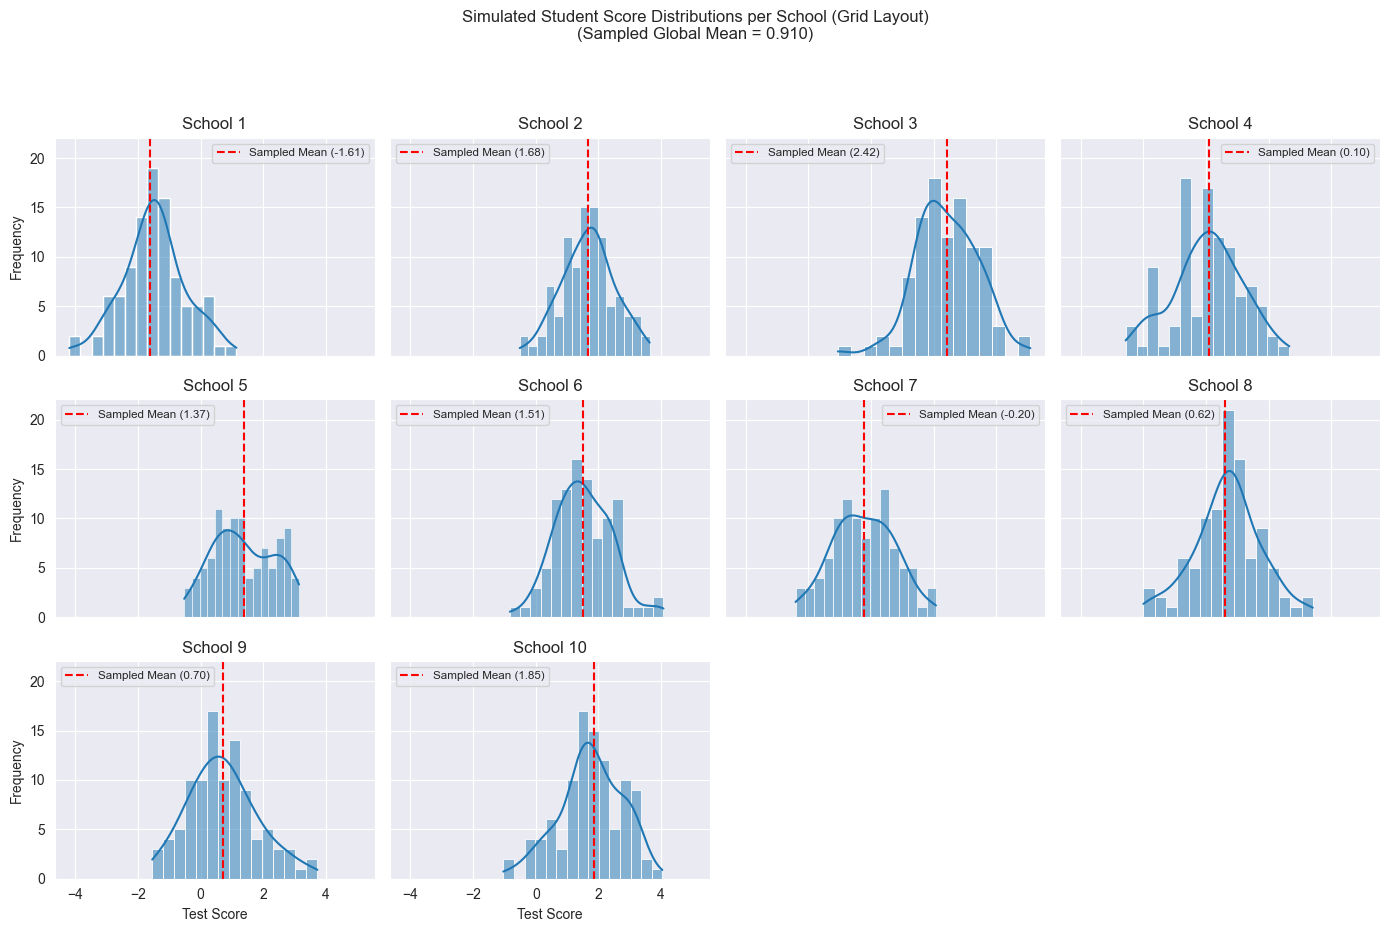

In [32]:
plot_test_scores(student_scores)